In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import scipy

In [2]:
import os
import zipfile

# Loading data

In [3]:
data = pd.read_csv('archive/ml-100k/u.data', sep='\t', header=None,
                  names=('user_id', 'movie_id', 'rating', 'time'))
# Convert Unix seconds to a Pandas timestamp:
data['time'] = pd.to_datetime(data['time'], unit='s')

In [4]:
data

,user_id,movie_id,rating,time
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16
...,...,...,...,...
99995,880,476,3,1997-11-22 05:10:44
99996,716,204,5,1997-11-17 19:39:03
99997,276,1090,1,1997-09-20 22:49:55
99998,13,225,2,1997-12-17 22:52:36


In [48]:
(data['user_id'] == 196).sum(axis=0)

39

In [5]:
data.value_counts('time').sort_values(ascending=False)

time
1998-03-27 21:20:06    12
1998-03-31 22:28:39    10
1998-02-23 00:18:56    10
1997-11-21 19:03:19    10
1998-01-23 09:28:55    10
                       ..
1997-11-10 20:35:14     1
1997-11-10 20:35:59     1
1997-11-10 20:37:48     1
1997-11-10 20:38:55     1
1997-12-21 02:33:15     1
Length: 49282, dtype: int64

In [6]:
data.describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


From above cell its clear that, this dataset contain total number of 1682 movies rated by 943 users. The maximum rating for any movie can be 5, and the minimum can be 1. All these ratings are integers but we can also try to predict ratings with decimal pointers as well.

# Exploring the data

This section is partly optional, its just to get some visions towards the kind of data we are going to handle, its complexity, its broadness, etc.

We'll explore the u.item file in the dataset. This contain some useful information about the movies.

In [7]:
movies = pd.read_csv('archive/ml-100k/u.item', sep='|', header=None,
                    encoding='ISO-8859-1', index_col=0,
                    names=('movie_id', 'movie_title'), usecols=[0, 1])

In [8]:
movies

,movie_title
movie_id,
1,Toy Story (1995)
2,GoldenEye (1995)
3,Four Rooms (1995)
4,Get Shorty (1995)
5,Copycat (1995)
...,...
1678,Mat' i syn (1997)
1679,B. Monkey (1998)
1680,Sliding Doors (1998)


In [56]:
movie_group = data.groupby('movie_id')
movie_stats = movies.\
    join(movie_group.size().rename('num_ratings')).\
    join(movie_group.mean()['rating'].rename('avg_rating'))

In [57]:
movie_stats.sort_values('num_ratings', ascending=False)[:30]

,movie_title,num_ratings,avg_rating
movie_id,,,
50,Star Wars (1977),583,4.358491
258,Contact (1997),509,3.803536
100,Fargo (1996),508,4.155512
181,Return of the Jedi (1983),507,4.007890
294,Liar Liar (1997),485,3.156701
286,"English Patient, The (1996)",481,3.656965
288,Scream (1996),478,3.441423
1,Toy Story (1995),452,3.878319
300,Air Force One (1997),431,3.631090


# Utility Matrix

The notion of the _utility_ matrix comes up in many methods as a way of expressing the ratings data. For one thing, this opens up the data to an array of linear algebra operations (such as matrix multiplication and SVD) that are useful for transforming the data, meaningful for interpreting it, very readily-available and optimized, and provide a common language for discussing and analyzing what we are actually what we are actually doing to the data. 

In a utility matrix, each row represents one user, each column represents one item (a movie, in this case), and each element represents a user's rating of an item. If we have n users and m movies, then this a n x m matrix U.

In [11]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.25, random_state=42)

The below code cell convert our data into a utility matrix. This is a very simple Numpy operation.

In [12]:
max_user = int(data['user_id'].max() + 1)
max_movie = int(data['movie_id'].max() + 1)
max_user, max_movie

(944, 1683)

In [13]:
def df2mat(df):
    m = np.zeros((max_user, max_movie))  # creates a matrix with all values zeros (943, 1680)
    m[df['user_id'], df['movie_id']] = df['rating']  # fill ratings wherever values available
    return m, m > 0

train_mat_data, train_mask_data = df2mat(train_data)
val_mat_data, val_mask_data = df2mat(val_data)

We will use a mask for some later steps, hence the m > 0 step; ratings go only from 1 to 5, so values 0 are automatically unknown/missing data.

In [14]:
train_mat_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 4., 0., ..., 0., 0., 0.],
       ...,
       [0., 5., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 5., ..., 0., 0., 0.]])

In [15]:
train_data[:10]

,user_id,movie_id,rating,time
98980,811,901,4,1998-02-02 00:02:51
69824,804,755,3,1997-11-13 18:21:45
9928,52,287,5,1997-12-24 00:12:37
75599,735,181,4,1997-10-12 23:23:24
95621,897,96,5,1997-11-20 01:47:10
80724,934,83,4,1998-03-29 17:17:11
78925,933,1,3,1997-09-21 15:04:54
14672,57,225,3,1998-01-01 23:40:39
76016,389,199,5,1997-11-22 02:23:08
95628,759,181,5,1997-09-25 22:49:58


Let's check that the matrix does in fact have the same data

In [16]:
user_ids = [train_data.iloc[:10].user_id]
movie_ids = [train_data.iloc[:10].movie_id]

print(train_mat_data[user_ids, movie_ids])
[train_data.iloc[:10].rating]

[[4. 3. 5. 4. 5. 4. 3. 3. 5. 5.]]


[98980    4
 69824    3
 9928     5
 75599    4
 95621    5
 80724    4
 78925    3
 14672    3
 76016    5
 95628    5
 Name: rating, dtype: int64]

# Slope One Predictors

In [17]:
pd.merge(movies, train_data[train_data.user_id == 818],
         right_on='movie_id',
         left_index=True)

,movie_title,user_id,movie_id,rating,time
84708,"Devil's Own, The (1997)",818,245,4,1998-04-06 13:48:35
90988,Contact (1997),818,258,4,1998-04-06 13:45:01
76614,Starship Troopers (1997),818,271,4,1998-04-06 13:46:29
59919,"English Patient, The (1996)",818,286,4,1998-04-06 13:43:42
93971,Scream (1996),818,288,5,1998-04-06 13:46:04
75738,Air Force One (1997),818,300,2,1998-04-06 13:43:42
82866,Ulee's Gold (1997),818,303,5,1998-04-06 13:43:42
86746,Midnight in the Garden of Good and Evil (1997),818,312,2,1998-04-06 13:49:06
99817,Titanic (1997),818,313,4,1998-04-06 13:42:53
63267,Murder at 1600 (1997),818,322,2,1998-04-06 13:46:29


In [18]:
movies[movies.index == 316]

,movie_title
movie_id,
316,As Good As It Gets (1997)


In [19]:
users_df = train_data[train_data.user_id == 818][['movie_id']].\
    merge(train_data, on='movie_id')[['movie_id', 'user_id', 'rating']].\
    merge(train_data[train_data.movie_id == 316], on='user_id')

users_df[:10]

,movie_id_x,user_id,rating_x,movie_id_y,rating_y,time
0,690,126,3,316,4,1998-02-19 02:27:11
1,288,126,4,316,4,1998-02-19 02:27:11
2,322,126,3,316,4,1998-02-19 02:27:11
3,300,126,4,316,4,1998-02-19 02:27:11
4,258,126,4,316,4,1998-02-19 02:27:11
5,313,126,5,316,4,1998-02-19 02:27:11
6,245,126,3,316,4,1998-02-19 02:27:11
7,346,126,3,316,4,1998-02-19 02:27:11
8,286,126,3,316,4,1998-02-19 02:27:11
9,328,126,5,316,4,1998-02-19 02:27:11


Now we can easily find the deviation of each individual rating:

In [20]:
users_df['rating_dev'] = users_df['rating_y'] - users_df['rating_x']
# A more cooler syntax
# users_df = users_df.assign(rating_dev = users_df.rating_y - users_df.rating_x)

users_df[:10]

,movie_id_x,user_id,rating_x,movie_id_y,rating_y,time,rating_dev
0,690,126,3,316,4,1998-02-19 02:27:11,1
1,288,126,4,316,4,1998-02-19 02:27:11,0
2,322,126,3,316,4,1998-02-19 02:27:11,1
3,300,126,4,316,4,1998-02-19 02:27:11,0
4,258,126,4,316,4,1998-02-19 02:27:11,0
5,313,126,5,316,4,1998-02-19 02:27:11,-1
6,245,126,3,316,4,1998-02-19 02:27:11,1
7,346,126,3,316,4,1998-02-19 02:27:11,1
8,286,126,3,316,4,1998-02-19 02:27:11,1
9,328,126,5,316,4,1998-02-19 02:27:11,-1


...and then turn this to an average deviation by grouping them by _movie_id_x_:

In [21]:
rating_dev = users_df.groupby('movie_id_x').mean()['rating_dev']
movies.join(rating_dev, how='inner')

,movie_title,rating_dev
245,"Devil's Own, The (1997)",1.000000
258,Contact (1997),0.547170
271,Starship Troopers (1997),1.090909
286,"English Patient, The (1996)",0.800000
288,Scream (1996),0.863636
300,Air Force One (1997),0.680000
303,Ulee's Gold (1997),0.740741
312,Midnight in the Garden of Good and Evil (1997),1.035714
313,Titanic (1997),-0.018519
322,Murder at 1600 (1997),1.035714


Now we can produce a prediction from each deviation above by adding it to each of user 818's ratings for the respective movies:

In [22]:
df = train_data[train_data.user_id == 818].\
    join(rating_dev, on='movie_id')

df = df.assign(rating_adj = df['rating'] + df['rating_dev'])[['user_id','movie_id',
                                                              'rating', 'rating_adj']]
df.join(movies, on='movie_id')

,user_id,movie_id,rating,rating_adj,movie_title
71457,818,690,3,3.535714,Seven Years in Tibet (1997)
86746,818,312,2,3.035714,Midnight in the Garden of Good and Evil (1997)
93971,818,288,5,5.863636,Scream (1996)
63267,818,322,2,3.035714,Murder at 1600 (1997)
75738,818,300,2,2.680000,Air Force One (1997)
59490,818,1105,1,NaN,Firestorm (1998)
57989,818,912,3,5.000000,U.S. Marshalls (1998)
90988,818,258,4,4.547170,Contact (1997)
77096,818,875,1,3.090909,She's So Lovely (1997)
82866,818,303,5,5.740741,Ulee's Gold (1997)


and then produce the final prediction by averaging all these:

In [23]:
df['rating_adj'].mean()

4.423114942770879

We also happen to have the user's actual rating in the test set, so we can compare here:

In [24]:
val_data[(val_data.user_id == 818) & (val_data.movie_id == 316)]['rating'].iloc[0]

4

That was close enough. Good going!!

## Weighted Slope One

In [25]:
num_ratings = users_df.groupby('movie_id_x').count()['rating_dev'].rename('num_ratings')
movies.join(num_ratings, how='inner')

,movie_title,num_ratings
245,"Devil's Own, The (1997)",32
258,Contact (1997),53
271,Starship Troopers (1997),33
286,"English Patient, The (1996)",65
288,Scream (1996),44
300,Air Force One (1997),50
303,Ulee's Gold (1997),27
312,Midnight in the Garden of Good and Evil (1997),28
313,Titanic (1997),54
322,Murder at 1600 (1997),28


We can see some of the movies have very low representation in the _num_ratings_ but still they contribute equally for the predictions. This may result in some faulty predictions. 
      <br> So we can set some weights to each movie on the basis of their representation in calculating standard deviations.

In [26]:
df = df.join(num_ratings, on='movie_id')
df = df.assign(rating_weighted = df['rating_adj'] * df['num_ratings'])

In [27]:
df

,user_id,movie_id,rating,rating_adj,num_ratings,rating_weighted
71457,818,690,3,3.535714,28.0,99.0
86746,818,312,2,3.035714,28.0,85.0
93971,818,288,5,5.863636,44.0,258.0
63267,818,322,2,3.035714,28.0,85.0
75738,818,300,2,2.680000,50.0,134.0
59490,818,1105,1,NaN,NaN,NaN
57989,818,912,3,5.000000,4.0,20.0
90988,818,258,4,4.547170,53.0,241.0
77096,818,875,1,3.090909,11.0,34.0
82866,818,303,5,5.740741,27.0,155.0


In [28]:
df['rating_weighted'].sum() / df['num_ratings'].sum()

4.450606585788561

# SVD (Singular Value Decomposition)

In [29]:
# Hyperparameters (using Surprise defaults):
gamma = 0.005  # learning rate
lambda_ = 0.02
factors = 100  # no. of factors that you want to include
num_epochs = 20

In [30]:
class SVDModel(object):
    def __init__(self, num_items, num_users, mean,
                num_factors=100, init_variance=0.1):
        self.mu = mean
        self.num_items = num_items
        self.num_users = num_users
        self.num_factors = num_factors
        # Deviation, per-item
        self.b_i = np.zeros((num_items,))
        # Deviation, per-user:
        self.b_u = np.zeros((num_users,))
        # Factors matrices:
        self.q = np.random.randn(num_factors, num_items) * init_variance
        self.p = np.random.randn(num_factors, num_users) * init_variance
        
    def predict(self, items, users):
        # We don't multiply items and users like matrices here
        # Rather, we just do row-by-row dot products.
        # Matrix multiply would give us every combination of item and user
        # which isn't what we want
        return self.mu + \
               self.b_i[items] + \
               self.b_u[users] + \
               (self.q[:, items] * self.p[:, users]).sum(axis=0)
    
    def error(self, items, users, ratings):
        p = self.predict(items, users)
        d = p - ratings
        rmse = np.sqrt(np.square(d).sum() / items.size)
        mae = np.abs(d).sum() / items.size
        return rmse, mae
    
    def update_by_gradient(self, i, u, r_ui, lambda_, gamma):
        e_ui = r_ui - self.predict(i, u)  # r_ui is the actual value
        dbi = gamma * (e_ui - lambda_ * self.b_u[u])
        dbu = gamma * (e_ui - lambda_ * self.b_i[i])
        dpu = gamma * (e_ui * self.q[:, i] - lambda_ * self.p[:, u])
        dqi = gamma * (e_ui * self.p[:, u] - lambda_ * self.q[:, i])
        self.b_i[i] += dbi
        self.b_u[u] += dbu
        self.p[:,u] += dpu
        self.q[:,i] += dqi
        
    def train(self, items, users, ratings, gamma=0.005, lambda_=0.02,
             num_epochs=20, epoch_callback=None):
        """"Train with Stochastic gradient descent"""
        for epoch in range(num_epochs):
            for idx in np.random.permutation(len(items)):
                i, u, r_ui = items[idx], users[idx], ratings[idx]
                self.update_by_gradient(i, u, r_ui, lambda_, gamma)
            if epoch_callback:
                epoch_callback(self, epoch, num_epochs)

## Running and Testing

In [31]:
movies_train = train_data['movie_id'].values
users_train = train_data['user_id'].values
ratings_train = train_data['rating'].values
movies_val = val_data['movie_id'].values
users_val = val_data['user_id'].values
ratings_val = val_data['rating'].values

def at_epoch(self, epoch, num_epochs):
    train_rmse, train_mae = self.error(movies_train, users_train, ratings_train)
    val_rmse, val_mae = self.error(movies_val, users_val, ratings_val)
    print("Epoch {:02d}/{}; Training: MAE={:.3f} RMSE={:.3f}, Testing: MAE={:.3f} RMSE={:.3f}".format(epoch + 1, num_epochs, train_mae, train_rmse, val_mae, val_rmse))

In [32]:
svd = SVDModel(max_movie, max_user, data['rating'].mean(), num_factors=100)
svd.train(movies_train, users_train, ratings_train, epoch_callback=at_epoch)

Epoch 01/20; Training: MAE=0.806 RMSE=0.996, Testing: MAE=0.816 RMSE=1.010
Epoch 02/20; Training: MAE=0.763 RMSE=0.955, Testing: MAE=0.783 RMSE=0.982
Epoch 03/20; Training: MAE=0.741 RMSE=0.931, Testing: MAE=0.769 RMSE=0.969
Epoch 04/20; Training: MAE=0.726 RMSE=0.914, Testing: MAE=0.763 RMSE=0.962
Epoch 05/20; Training: MAE=0.714 RMSE=0.900, Testing: MAE=0.758 RMSE=0.958
Epoch 06/20; Training: MAE=0.703 RMSE=0.887, Testing: MAE=0.755 RMSE=0.955
Epoch 07/20; Training: MAE=0.694 RMSE=0.875, Testing: MAE=0.753 RMSE=0.952
Epoch 08/20; Training: MAE=0.684 RMSE=0.864, Testing: MAE=0.751 RMSE=0.951
Epoch 09/20; Training: MAE=0.675 RMSE=0.852, Testing: MAE=0.750 RMSE=0.949
Epoch 10/20; Training: MAE=0.665 RMSE=0.840, Testing: MAE=0.749 RMSE=0.948
Epoch 11/20; Training: MAE=0.655 RMSE=0.827, Testing: MAE=0.748 RMSE=0.947
Epoch 12/20; Training: MAE=0.645 RMSE=0.814, Testing: MAE=0.747 RMSE=0.946
Epoch 13/20; Training: MAE=0.634 RMSE=0.801, Testing: MAE=0.745 RMSE=0.945
Epoch 14/20; Training: MA

In [81]:
val_rmse, val_mae = svd.error(movies_val, users_val, ratings_val)
val_results = [("", "SVD", val_mae, val_rmse)]

## Another way to employ SVD

In [33]:
# Normailse the data first
normalised_mat = train_mat_data - np.asarray([np.mean(train_mat_data, axis=1)]).T  # reduce the mean off

# Computing the singular value decomposition of normalised array
A = normalised_mat.T / np.sqrt(train_mat_data.shape[0] - 1)
U, S, V = np.linalg.svd(A)

# Function to calculate the cosine similarity 
def top_cosine_similarity(data, movie_id, top_n=10):
    index = movie_id - 1  # movie_id starts from 1 in the dataset
    movie_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

# Function to print top N similar movies
def print_similar_movies(movie_data, movie_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
    movie_data[movie_data.movie_id == movie_id].title.values[0]))
    for id in top_indexes + 1:
        print(movie_data[movie_data.movie_id == id].title.values[0])
        
# k-principal components to represent movies, movie_id to find recommendation
k = 50
movie_id = 10  
top_n = 10
sliced = V.T[:, :k]  # representative data
indexes = top_cosine_similarity(sliced, movie_id, top_n)

# Printing the top N similar movies
print_similar_movies(data, movie_id, indexes)

AttributeError: 'DataFrame' object has no attribute 'title'

# Visualization 

As this is a latent-factor model, it might have some other things to tell us than predictions. We can easily train on a much lower-dimensional concept space, and visualize directly how it is mapping movies. Below I use just 4 dimensions/factors, and pick pairs of 2 dimensions to plot.

In [35]:
svd4 = SVDModel(max_movie, max_user, data['rating'].mean(), 4)
svd4.train(train_data['movie_id'].values, train_data['user_id'].values, train_data['rating'].values, epoch_callback=at_epoch)

Epoch 01/20; Training: MAE=0.811 RMSE=1.000, Testing: MAE=0.814 RMSE=1.006
Epoch 02/20; Training: MAE=0.773 RMSE=0.967, Testing: MAE=0.780 RMSE=0.978
Epoch 03/20; Training: MAE=0.758 RMSE=0.952, Testing: MAE=0.767 RMSE=0.966
Epoch 04/20; Training: MAE=0.748 RMSE=0.942, Testing: MAE=0.759 RMSE=0.959
Epoch 05/20; Training: MAE=0.742 RMSE=0.935, Testing: MAE=0.755 RMSE=0.954
Epoch 06/20; Training: MAE=0.738 RMSE=0.931, Testing: MAE=0.752 RMSE=0.951
Epoch 07/20; Training: MAE=0.734 RMSE=0.927, Testing: MAE=0.750 RMSE=0.949
Epoch 08/20; Training: MAE=0.731 RMSE=0.924, Testing: MAE=0.748 RMSE=0.947
Epoch 09/20; Training: MAE=0.729 RMSE=0.921, Testing: MAE=0.747 RMSE=0.946
Epoch 10/20; Training: MAE=0.727 RMSE=0.919, Testing: MAE=0.746 RMSE=0.946
Epoch 11/20; Training: MAE=0.726 RMSE=0.917, Testing: MAE=0.746 RMSE=0.945
Epoch 12/20; Training: MAE=0.724 RMSE=0.916, Testing: MAE=0.745 RMSE=0.944
Epoch 13/20; Training: MAE=0.723 RMSE=0.914, Testing: MAE=0.745 RMSE=0.944
Epoch 14/20; Training: MA

To limit the data we will use just the top 50 movies (by number of ratings):

In [36]:
top50 = movie_stats.sort_values('num_ratings', ascending=False)[:50]
ids_top50 = top50.index.values

In [39]:
factors = svd4.q[:, ids_top50].T
means, stds = factors.mean(axis=0), factors.std(axis=0)
factors[:] = (factors - means) / stds

First two dimensions:

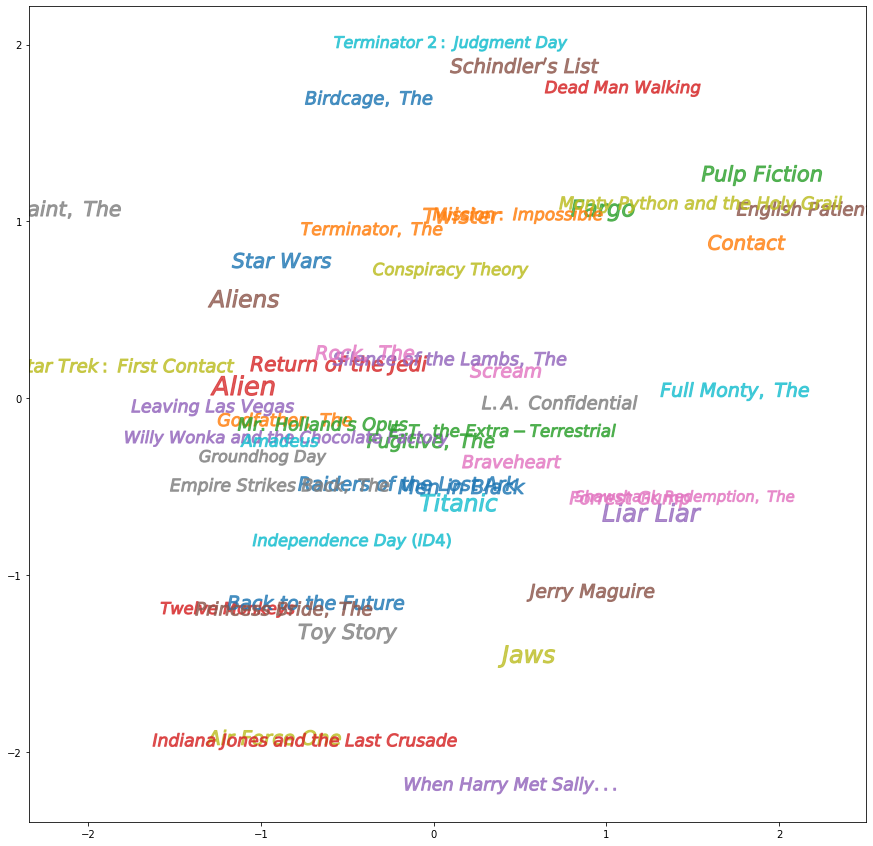

In [42]:
plt.figure(figsize=(15, 15))
markers = ["$ {} $".format("\ ".join(m.split(" ")[:-1])) for m in top50["movie_title"]]
for i,item in enumerate(factors):
    l = len(markers[i])
    plt.scatter(item[0], item[1], marker = markers[i], alpha=0.75, s = 50 * (l**2))
plt.show()

Last two:

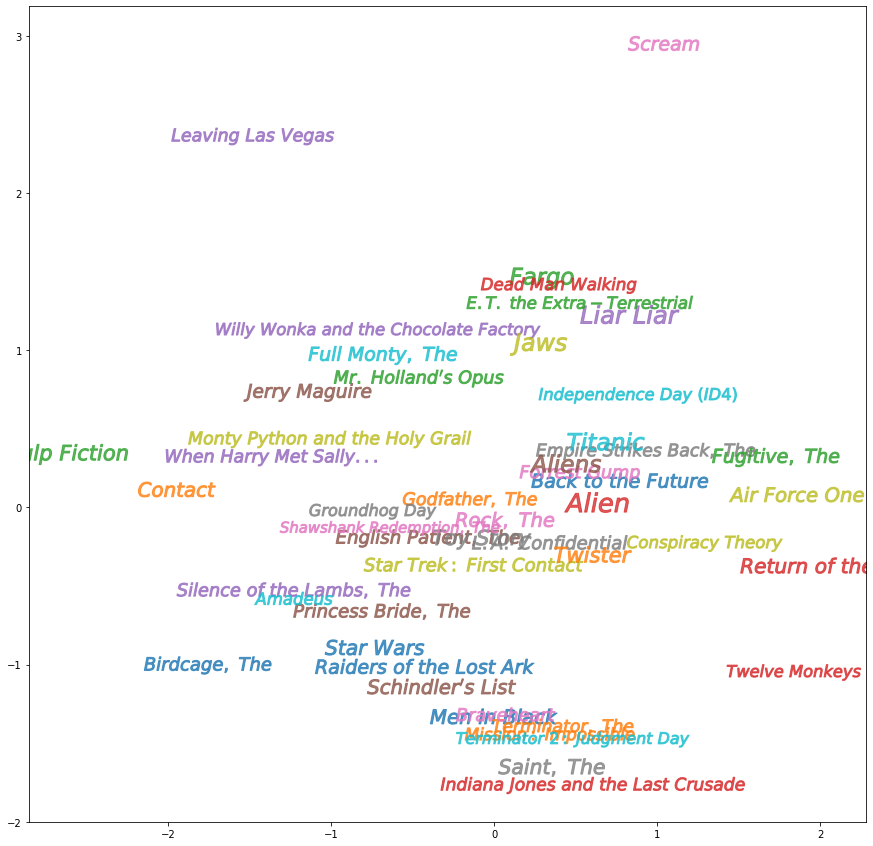

In [43]:
plt.figure(figsize=(15,15))
markers = ["$ {} $".format("\ ".join(m.split(" ")[:-1])) for m in top50["movie_title"]]
for i,item in enumerate(factors):
    l = len(markers[i])
    plt.scatter(item[2], item[3], marker = markers[i], alpha=0.75, s = 50 * (l**2))
plt.show()

# Implementation using Scikit-surprise

[Surprise](http://surpriselib.com/) is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

Surprise already contain some core collabrative filtering algorithm like _baseline algorithms, neighbourhood methods, matrix factorization-based (SVD, PMF, SVD++, NMF)_ and many others. Also various [similarity measures](https://surprise.readthedocs.io/en/stable/similarities.html) (cosine, MSD, pearson..) are built-in.

In addition it already contain some popular dataset like Movielens, Jester already built-in.

A virtuous thing about scikit-surprise is that its [documentation](https://surprise.readthedocs.io/en/stable/index.html) is made clear, precise and easy to understand. 

In [66]:
import surprise
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

In [68]:
reader = surprise.Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['user_id', 'movie_id', 'rating']], reader)

In [72]:
# using random predictor
cv_random = cross_validate(surprise.NormalPredictor(), surprise_data, measures=['rmse', 'mae'], cv=5, verbose=True)

# using slope one
cv_s1 = cross_validate(surprise.SlopeOne(), surprise_data, measures=['rmse', 'mae'], cv=5, verbose=True)

# using SVD algorithm
algo = SVD()
cv_svd = cross_validate(algo, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5223  1.5153  1.5248  1.5186  1.5327  1.5228  0.0059  
MAE (testset)     1.2236  1.2194  1.2276  1.2189  1.2271  1.2233  0.0037  
Fit time          0.11    0.13    0.13    0.13    0.13    0.13    0.01    
Test time         0.11    0.19    0.11    0.19    0.11    0.14    0.04    
Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9449  0.9458  0.9491  0.9434  0.9408  0.9448  0.0027  
MAE (testset)     0.7430  0.7455  0.7448  0.7404  0.7388  0.7425  0.0025  
Fit time          0.66    0.72    0.69    0.66    0.75    0.70    0.04    
Test time         3.09    2.95    3.01    2.98    3.12    3.03    0.06    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std  

In [79]:
cv_svd['test_rmse'].mean()

0.9369355281564014

# Overall Result

Let's compare the results of the algorithms that we programmed, and the different built-in algorithms that we used from surprise. We'll try to encapsulate all the result in a table.

In [100]:
val_results

[('', 'SVD', 0.7406422274881949, 0.9402944284975451),
 ('', 'Slope One', 0.781966, 1.015133),
 ('', 'Slope One', 0.781966, 1.015133),
 ('', 'Slope One', 0.781966, 1.015133),
 ('', 'Slope One', 0.781966, 1.015133),
 ('', 'Slope One', 0.781966, 1.015133)]

In [105]:
val_results.append(("", "Slope One", 0.781966, 1.015133))
ov_result = {'Implementation': ['Programmed', 'Programmed', 'Surprise', 'Surprise', 'Surprise'],
            'Algorithm': ['Slope One', 'SVD', 'Random', 'Slope One', 'SVD'],
            'RMSE(test)': [val_results[1][2], val_results[0][2], cv_random['test_rmse'].mean(), cv_s1['test_rmse'].mean(), cv_svd['test_rmse'].mean()],
            'MAE(test)': [val_results[1][3], val_results[0][3], cv_random['test_mae'].mean(), cv_s1['test_mae'].mean(), cv_svd['test_mae'].mean()]
            }
ov_result = pd.DataFrame(ov_result)
ov_result

,Implementation,Algorithm,RMSE(test),MAE(test)
0,Programmed,Slope One,0.781966,1.015133
1,Programmed,SVD,0.740642,0.940294
2,Surprise,Random,1.522771,1.223339
3,Surprise,Slope One,0.944807,0.742516
4,Surprise,SVD,0.936936,0.738349


## Tune algorithm parameters with GridSearchCV

In [71]:
from surprise.model_selection import GridSearchCV

# dictionary of parameters 
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
grid_search.fit(surprise_data)

# best rmse score
print(grid_search.best_score['rmse'])

# combination of parameters that gave the best rmse score
print(grid_search.best_params['rmse'])

0.9606753780336191
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
